In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [3]:
csv_path = '2025-11-02_selected.csv'
sel = pd.read_csv(csv_path)
sel

,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,...,artifacts.valid,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,dims_error
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.294375e-08
1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.319075e-08
2,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},1,{'ChestOfDrawers'},1,True,(),0.019631,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,8.319422e-08
3,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Desktop', 'Computer'}",2,"{'Desktop', 'Computer'}",2,True,(),0.025252,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.077898e-07
4,wss.107637b6bdf8129d4904d89e9169817b,{'Couch'},1,{'Couch'},1,True,(),0.022625,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.520307e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,wss.d81f943065391492a7e760c0b399301,"{'FoodItem', 'Bowl', '_StanfordSceneDBModels',...",4,"{'FoodItem', 'Bowl', 'FruitBowl'}",3,True,(),0.001381,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1112,wss.d8d4004791c4f61b80fa98b5eeb7036c,"{'_StanfordSceneDBModels', 'Book'}",2,{'Book'},1,True,(),0.000002,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1113,wss.e8add7acb28e2505fd40810f48721e8b,"{'Bed', 'DoubleBed'}",2,"{'Bed', 'DoubleBed'}",2,True,(),0.009245,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1114,wss.f6420a3a3addd027f67be63aca8832dd,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.027262,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,NaN


In [4]:
base_dir = '2025-11-04_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-02_config.json')
len(grid)

1116

In [5]:
base_dir = '2025-11-06_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1116

In [6]:
base_dir = '2025-11-08_optimize' # fixed node labeling- use cell labels as GT, map cell -> point data, P0 scalars in forward sim

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config {config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1116

In [7]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=True)
except OSError:
    jobs = ps.load(base_dir)

jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,output_path,log_dir,stdout_path,stderr_path,params_json,params_hash,params.subject,params.variant,params.config
0,db2c4f1ec0622d3a,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",db2c4f1ec0622d3a,wss.100f39dce7690f59efb94709f30ce0d2,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,e3d5069a003c0389,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",e3d5069a003c0389,wss.101354f9d8dede686f7b08d9de913afe,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,2bbb37117dbf41b9,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",2bbb37117dbf41b9,wss.1029fd5d71a06ea32ea98d69e91ba870,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
3,d32b82ea5f1dd332,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",d32b82ea5f1dd332,wss.102a6b7809f4e51813842bc8ef6fe18,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
4,7555bb1078b8b24a,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",7555bb1078b8b24a,wss.107637b6bdf8129d4904d89e9169817b,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,45faf486366d2316,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",45faf486366d2316,wss.d81f943065391492a7e760c0b399301,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
1112,a1c698834094bd5b,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""config"": ""2025-11-05_config.json"", ""subject""...",a1c698834094bd5b,wss.d8d4004791c4f61b80fa98b5eeb7036c,2025-11-02,/ocean/projects/asc170022p/mtragoza/lung-proje...
1113,0c8e9e2dcb96e5a7,NEW,0,<NA>,<NA>,<NA>,<NA>,<NA>,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,<NA>,<NA>,"{""confi

In [48]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params_json,params_hash,params.subject,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at
job_state,,,,,,,,,,,,,,,,,,,,,
PENDING,1116,1116,1116,1116,1116,0,0,1116,1116,1116,...,1116,1116,1116,1116,1116,0,1116,1116,0,0


In [49]:
jobs = ps.collect(jobs)

In [40]:
print(jobs[jobs.job_state == 'FAILED'].iloc[0].stderr)

Traceback (most recent call last):
  File "/ocean/projects/asc170022p/mtragoza/lung-project/optimize.py", line 96, in <module>
    main(sys.argv[1:])
  File "/ocean/projects/asc170022p/mtragoza/lung-project/optimize.py", line 68, in main
    metrics = run_optimize(
              ^^^^^^^^^^^^^
  File "/ocean/projects/asc170022p/mtragoza/lung-project/project/preprocessing/api.py", line 430, in optimize_elasticity_field
    u_obs_nodes = mesh.point_data['u'] # world units
                  ~~~~~~~~~~~~~~~^^^^^
KeyError: 'u'



In [47]:
jobs = ps.submit(jobs)

In [205]:
print(jobs[jobs.job_state == 'FAILED'].iloc[0].stdout)

    └── 'unit':     0.001709213850777
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2025-11-02/4ec31503deb053636c19a70b7478f722/meshes/node_values.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2025-11-02/4ec31503deb053636c19a70b7478f722/masks/regions.nii.gz
Optimizing elasticity to match observed displacement
Optimizing global parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	1.9750e+00 (nan)	3.3804e+00 (nan)	3.3804e+00 (nan)
1	1.7938e-02 (9.9092e-01)	3.3801e+00 (9.9989e-01)	3.3801e+00 (1.1440e-04)
Optimization converged
Optimizing local parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	1.7937e-02 (nan)	8.0543e+00 (nan)	8.0543e+00 (nan)
1	2.6422e-04 (9.8527e-01)	1.9393e+01 (2.4078e+00)	1.9393e+01 (2.0216e+00)
2	1.7697e-04 (3.3020e-01)	3.2160e+01 (3.9929e+00)	3.2160e+01 (7.4417e-01)
3	1.3315e-04 (2.4763e-01)	3.9660e+01 (4.9241e+00)	3.9660e+01 (2.4744e-01)
4	1.28

In [118]:
df = ps.outputs(jobs[jobs.job_state == 'COMPLETED'], )

In [119]:
df.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

,u.norm,u.rms,u.rmse,u.nrmse,u.pcorr,u.scorr,E.norm,E.rms,E.rmse,E.nrmse,E.pcorr,E.scorr,res.norm,res.rms
count,1110.000000,1110.000000,1110.000000,1110.000000,1109.000000,1109.000000,1.110000e+03,1.110000e+03,1.110000e+03,1.110000e+03,1097.000000,1097.000000,1110.000000,1110.000000
mean,2.612637,4.494337,0.022164,0.005879,0.999550,0.995008,6.018583e+15,1.815102e+17,1.815102e+17,7.107360e+13,0.449002,0.642509,1.277817,2.377310
std,38.803091,67.812945,0.394687,0.028418,0.004090,0.012383,7.505085e+16,2.467223e+18,2.467223e+18,9.664184e+14,0.401778,0.221563,19.088484,35.914093
min,0.000000,0.000000,0.000000,0.000000,0.931115,0.829811,1.249565e+02,1.476572e+02,1.936699e+02,9.068422e-02,-0.354894,-0.327648,0.000017,0.000018
1%,0.001404,0.003832,0.000008,0.000516,0.980317,0.937107,1.732241e+03,1.868272e+03,2.836749e+02,1.312724e-01,-0.254360,0.045451,0.000180,0.000335
5%,0.010331,0.022612,0.000043,0.000750,0.999980,0.988065,2.009270e+03,2.151060e+03,5.667005e+02,1.712003e-01,-0.137077,0.217000,0.000742,0.001275
25%,0.090470,0.172749,0.000318,0.001370,0.999996,0.995395,2.540569e+03,2.806392e+03,8.866723e+02,2.864606e-01,0.020375,0.493561,0.017959,0.032791
50%,0.269157,0.474155,0.000937,0.001917,0.999998,0.997356,3.097524e+03,3.688572e+03,1.284743e+03,4.829020e-01,0.494743,0.697477,0.131359,0.253682
75%,0.742824,1.264562,0.002733,0.002761,0.999999,0.998569,4.358667e+03,5.622276e+03,3.888013e+03,1.381850e+00,0.849466,0.823300,0.786633,1.494796
95%,2.848322,4.298572,0.013464,0.005944,1.000000,0.999469,2.368944e+06,2.876130e+07,2.876117e+07,1.100404e+04,0.936343,0.904231,1.673111,2.942423


In [120]:
sys.path.append('../..')
import project.visual.matplotlib as mpl_viz
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
nnas = df.isna().sum()
nnas[nnas > 0]

u.norm        5
u.rms         5
u.rmse        5
u.nrmse       5
u.pcorr       6
u.scorr       6
E.norm        5
E.rms         5
E.rmse        5
E.nrmse       5
E.pcorr      18
E.scorr      18
res.norm      5
res.rms       5
res_order     5
u_order       5
E_order       5
dtype: int64

In [141]:
df['has_na'] = df.isna().any(axis=1)
df['u_isna'] = df['u.norm'].isna()
df['E_isna'] = df['E.norm'].isna()
df['res_isna'] = df['res.norm'].isna()
df['ucorr_isna'] = df['u.pcorr'].isna()
df['Ecorr_isna'] = df['E.pcorr'].isna()

df.groupby(['has_na', 'u_isna', 'E_isna', 'res_isna', 'ucorr_isna', 'Ecorr_isna']).count()

dataset  subject  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                     
False  False  False  False    False      False          1097     1097   
True   False  False  False    False      True             12       12   
                              True       True              1        1   
       True   True   True     True       True              5        5   

                                                     variant  method  u.norm  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                            
False  False  False  False    False      False          1097    1097    1097   
True   False  False  False    False      True             12      12      12   
                              True       True              1       1       1   
       True   True   True     True       True              5       5       0   

                                                     u.rms  u.rmse  u.nrmse  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                           
False  False  False  False    False      False        1097    1097     1097   
True   False  False  False    False      True           12      12       12   
                              True       True            1       1        1   
       True   True   True     True       True            0       0        0   

                                                     u.pcorr  u.scorr  ...  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                    ...   
False  False  False  False    False      False          1097     1097  ...   
True   False  False  False    False      True             12       12  ...   
                              True       True              0        0  ...   
       True   True   True     True       True              0        0  ...   

                                                     res.norm  res.rms  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                      
False  False  False  False    False      False           1097     1097   
True   False  False  False    False      True              12       12   
                              True       True               1        1   
       True   True   True     True       True               0        0   

                                                     source_path  job_name  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                          
False  False  False  False    False      False              1097      1097   
True   False  False  False    False      True                 12        12   
                              True       True                  1         1   
       True   True   True     True       True                  5         5   

                                                     job_id  params_hash  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                        
False  False  False  False    False      False         1097         1097   
True   False  False  False    False      True            12           12   
                              True       True             1            1   
       True   True   True     True       True             5            5   

                                                     params.subject  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                   
False  False  False  False    False      False                 1097   
True   False  False  False    False      True                    12   
                              True       True                     1   
       True   True   True     True       True                     5   

                                                     params.variant  \
has_na u_isna E_isna res_isna ucorr_isna Ecorr_isna                   
False  False  False  False    False      False                 1097   
True   False  False  False    False      True                    12   
                              True       True                     1   
       True   True   True     True  

In [161]:
df['res_order'] = np.round(np.log10(df['res.rms']))
df.groupby(['res_order']).count()

,dataset,subject,variant,method,u.norm,u.rms,u.rmse,u.nrmse,u.pcorr,u.scorr,...,params.subject,params.variant,params.config,has_na,u_isna,E_isna,corr_isna,res_isna,ucorr_isna,Ecorr_isna
res_order,,,,,,,,,,,,,,,,,,,,,
-5.0,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
-4.0,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
-3.0,96,96,96,96,96,96,96,96,96,96,...,96,96,96,96,96,96,96,96,96,96
-2.0,168,168,168,168,168,168,168,168,168,168,...,168,168,168,168,168,168,168,168,168,168
-1.0,320,320,320,320,320,320,320,320,320,320,...,320,320,320,320,320,320,320,320,320,320
-0.0,471,471,471,471,471,471,471,471,471,471,...,471,471,471,471,471,471,471,471,471,471
1.0,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
3.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [164]:
df['u_order'] = np.round(np.log10(df['u.nrmse']))
df.groupby(['u_order']).count()

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dataset,subject,variant,method,u.norm,u.rms,u.rmse,u.nrmse,u.pcorr,u.scorr,...,params.variant,params.config,has_na,u_isna,E_isna,corr_isna,res_isna,ucorr_isna,Ecorr_isna,res_order
u_order,,,,,,,,,,,,,,,,,,,,,
-inf,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
-3.0,907,907,907,907,907,907,907,907,907,907,...,907,907,907,907,907,907,907,907,907,907
-2.0,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
-1.0,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
-0.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [178]:
df['E_order'] = np.round(np.log10(df['E.nrmse']))
df.groupby(['E_order']).count()

,dataset,subject,variant,method,u.norm,u.rms,u.rmse,u.nrmse,u.pcorr,u.scorr,...,has_na,u_isna,E_isna,corr_isna,res_isna,ucorr_isna,Ecorr_isna,res_order,u_order,failure_type
E_order,,,,,,,,,,,,,,,,,,,,,
-1.0,334,334,334,334,334,334,334,334,334,334,...,334,334,334,334,334,334,334,334,334,334
-0.0,562,562,562,562,562,562,562,562,561,561,...,562,562,562,562,562,562,562,562,562,562
1.0,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
2.0,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
3.0,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
4.0,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
5.0,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
6.0,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
7.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [186]:
def classify_failure(row):
    if row['u_isna'] or row['E_isna'] or row['res_isna']:
        return 'nan values'
    if row['E_order'] > 10:
        return 'elasticity blow-up'
    if row['u_order'] > -1:
        return 'displacement error'
    elif row['res_order'] > 1:
        return 'residual divergence'
    return 'ok'

df['failure_type'] = df.apply(classify_failure, axis=1)
df['failure_type'].value_counts()

failure_type
ok                     1095
elasticity blow-up       12
nan values                5
residual divergence       2
displacement error        1
Name: count, dtype: int64

<Axes: xlabel='Count', ylabel='E.nrmse'>

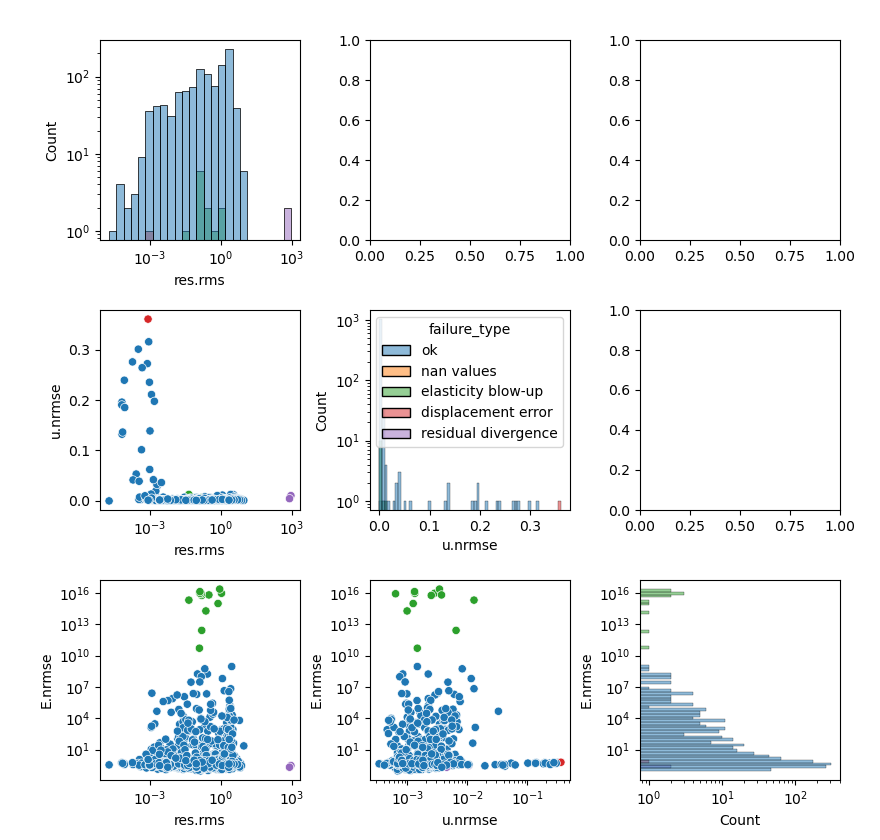

In [187]:
fig, axes = mpl_viz.subplot_grid(3, 3, ax_height=2, ax_width=2, padding=(1.0, 0.4, 0.6, 0.4), spacing=0.7) # lrbt

ax = axes[0,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='res.rms', hue='failure_type', legend=False, ax=ax)

ax = axes[1,0]
ax.set_xscale('log', base=10)
ax.set_xscale('log', base=10)
sns.scatterplot(df, x='res.rms', y='u.nrmse', hue='failure_type', legend=False, ax=ax)

ax = axes[2,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='res.rms', y='E.nrmse', hue='failure_type', legend=False, ax=ax)

ax = axes[1,1]
#ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='u.nrmse', hue='failure_type', legend=True, ax=ax)

ax = axes[2,1]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='u.nrmse', y='E.nrmse', hue='failure_type', legend=False, ax=ax)

ax = axes[2,2]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, y='E.nrmse', hue='failure_type', legend=False, ax=ax)


In [194]:
sel.merge(df, on='subject', how='inner')

,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,...,u_isna,E_isna,corr_isna,res_isna,ucorr_isna,Ecorr_isna,res_order,u_order,E_order,failure_type
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,(),...,False,False,False,False,False,False,-0.0,-3.0,-1.0,ok
1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,(),...,False,False,False,False,False,False,-1.0,-3.0,-1.0,ok
2,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},1,{'ChestOfDrawers'},1,True,(),0.019631,True,(),...,False,False,False,False,False,False,0.0,-3.0,1.0,ok
3,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Desktop', 'Computer'}",2,"{'Desktop', 'Computer'}",2,True,(),0.025252,True,(),...,False,False,False,False,False,False,-1.0,-3.0,1.0,ok
4,wss.107637b6bdf8129d4904d89e9169817b,{'Couch'},1,{'Couch'},1,True,(),0.022625,True,(),...,False,False,False,False,False,False,0.0,-2.0,-0.0,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,wss.d81f943065391492a7e760c0b399301,"{'FoodItem', 'Bowl', '_StanfordSceneDBModels',...",4,"{'FoodItem', 'Bowl', 'FruitBowl'}",3,True,(),0.001381,True,(),...,False,False,False,False,False,False,-2.0,-2.0,-0.0,ok
1111,wss.d8d4004791c4f61b80fa98b5eeb7036c,"{'_StanfordSceneDBModels', 'Book'}",2,{'Book'},1,True,(),0.000002,True,(),...,False,False,False,False,False,False,-2.0,-2.0,-1.0,ok
1112,wss.e8add7acb28e2505fd40810f48721e8b,"{'Bed', 'DoubleBed'}",2,"{'Bed', 'DoubleBed'}",2,True,(),0.009245,True,(),...,False,False,False,False,False,False,0.0,-3.0,-0.0,ok
1113,wss.f6420a3a3addd027f67be63aca8832dd,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.027262,True,(),...,False,False,False,False,False,False,-0.0,-3.0,-0.0,ok


In [197]:
df.to_csv('2025-11-05_optimized.csv', index=False)